In [247]:
import pandas as pd
import numpy as np
import io
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob # for sentiment analysis
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt
import string

In [250]:
from google.colab import files
uploaded=files.upload()

Saving avatar.xls to avatar (1).xls


In [261]:
data=pd.read_excel(io.BytesIO(uploaded['avatar.xls'])) 
data.head()

,Unnamed: 0,id,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
0,1,1,Water,1,The Boy in the Iceberg,1,Katara,Water. Earth. Fire. Air. My grandmother used t...,Water. Earth. Fire. Air. My grandmother used t...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
1,2,2,Water,1,The Boy in the Iceberg,1,Scene Description,"As the title card fades, the scene opens onto ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
2,3,3,Water,1,The Boy in the Iceberg,1,Sokka,It's not getting away from me this time. [Clos...,It's not getting away from me this time. Watc...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
3,4,4,Water,1,The Boy in the Iceberg,1,Scene Description,"The shot pans quickly from the boy to Katara, ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
4,5,5,Water,1,The Boy in the Iceberg,1,Katara,"[Happily surprised.] Sokka, look!","Sokka, look!","<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1


In [262]:
data.drop(data.columns[[0,1,3,5,7,9,10,11]], axis = 1, inplace = True)

In [263]:
data = data.rename(columns={"character_words":"dialogue"})

In [264]:
data.head()

,book,chapter,character,dialogue
0,Water,The Boy in the Iceberg,Katara,Water. Earth. Fire. Air. My grandmother used t...
1,Water,The Boy in the Iceberg,Scene Description,NaN
2,Water,The Boy in the Iceberg,Sokka,It's not getting away from me this time. Watc...
3,Water,The Boy in the Iceberg,Scene Description,NaN
4,Water,The Boy in the Iceberg,Katara,"Sokka, look!"


In [265]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13385 entries, 0 to 13384
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   book       13385 non-null  object
 1   chapter    13385 non-null  object
 2   character  13385 non-null  object
 3   dialogue   9991 non-null   object
dtypes: object(4)
memory usage: 418.4+ KB


In [266]:
data.isnull().sum()

book            0
chapter         0
character       0
dialogue     3394
dtype: int64

The NaN values in dialogue are mostly scene descriptions so we can drop them

In [267]:
data.shape

(13385, 4)

In [268]:
df = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [269]:
df.isnull().sum()

book         0
chapter      0
character    0
dialogue     0
dtype: int64

In [270]:
df.shape

(9991, 4)

In [271]:
df.head()

,book,chapter,character,dialogue
0,Water,The Boy in the Iceberg,Katara,Water. Earth. Fire. Air. My grandmother used t...
2,Water,The Boy in the Iceberg,Sokka,It's not getting away from me this time. Watc...
4,Water,The Boy in the Iceberg,Katara,"Sokka, look!"
5,Water,The Boy in the Iceberg,Sokka,"Sshh! Katara, you're going to scare it away. ..."
7,Water,The Boy in the Iceberg,Katara,"But, Sokka! I caught one!"


In [272]:
# Remove Characters that aren't the top 15 characters with respect to the dialogues spoken
remove = df.character.value_counts().iloc[15:].index.tolist()
for name in remove:
    df = df[df['character'] != name]

In [273]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['figure.facecolor'] = '#00000000'

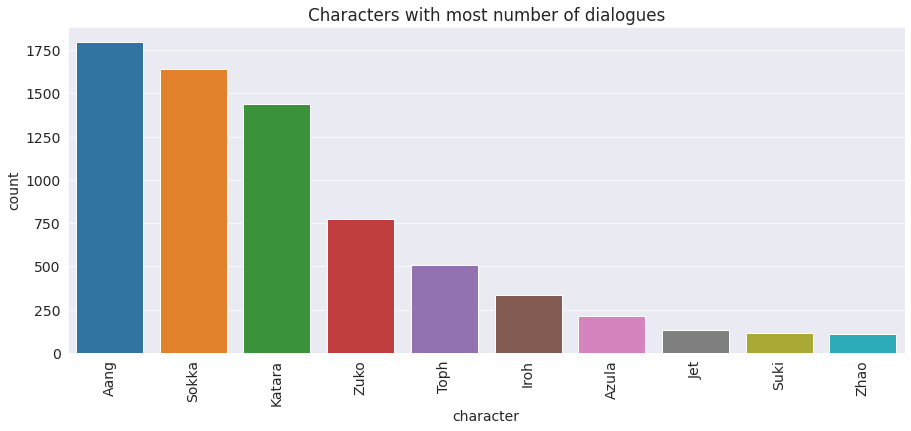

In [274]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.title('Characters with most number of dialogues')
sns.countplot(x = 'character', data = df, order = df.character.value_counts().iloc[:10].index)


In [275]:
df['word_count'] = df['dialogue'].str.split().str.len()

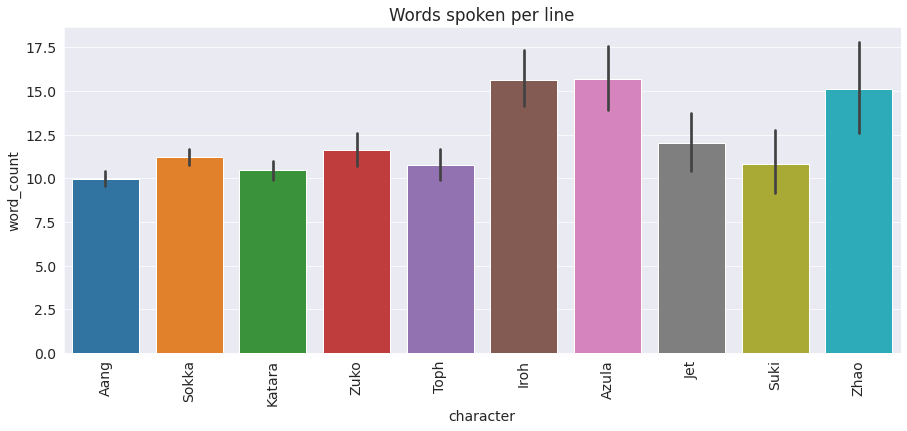

In [276]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.title('Words spoken per line')
sns.barplot(x='character',y='word_count',data=df, order = df.character.value_counts().iloc[:10].index)


**The scene where Azula flirts with Chan and Iroh singing leaves from the vine has the morst number of words per line**

In [277]:
total_sum = df.groupby(['character'])['word_count'].sum().reset_index()

In [278]:
total_sum = total_sum.sort_values(by='word_count', ascending=False)

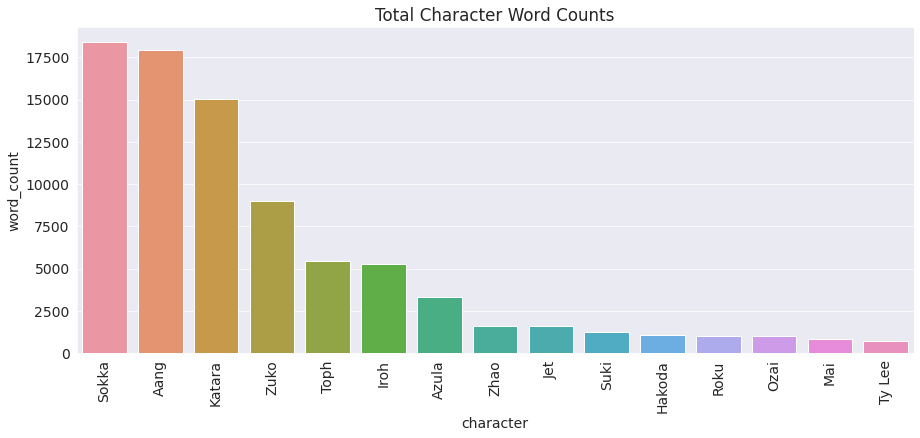

In [279]:
plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
plt.title('Total Character Word Counts')
sns.barplot(x='character',y='word_count',data=total_sum)

In [280]:
nltk.download

<bound method Downloader.download of <nltk.downloader.Downloader object at 0x7f1f5624f4d0>>

In [281]:
pip install nltk

In [282]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [283]:
# Clean and Normalize Text
# - tokenize
# - lowercase
# - remove punctuation
# - remove alphanumeric characters
# - remove stopwords

stop_words = set(stopwords.words('english'))

def clean(dialogue):
    dialogue = word_tokenize(dialogue)
    dialogue = [word.lower() for word in dialogue]
    punct = str.maketrans('', '', string.punctuation) 
    dialogue = [word.translate(punct) for word in dialogue] 
    dialogue = [word for word in dialogue if word.isalpha()]
    dialogue = [word for word in dialogue if not word in stop_words]
    return " ".join(dialogue)

df['clean_dialogue'] = df['dialogue'].apply(clean)

In [284]:
# Create Word Count Column for Clean Text
df['clean_word_count'] = df['clean_dialogue'].str.split().str.len()

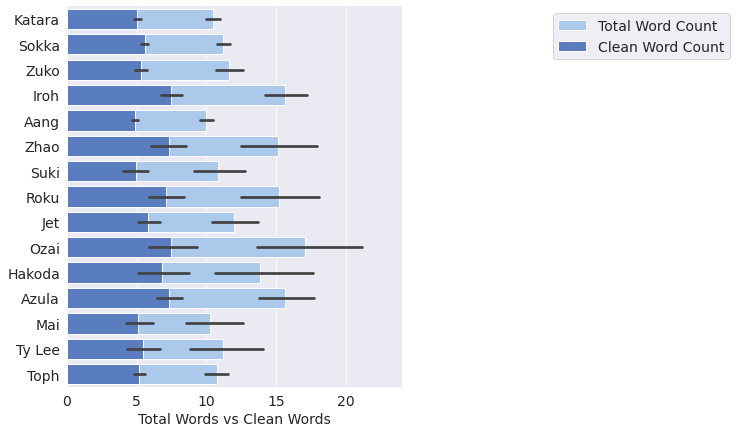

In [285]:
f, ax = plt.subplots(figsize=(6, 7))

sns.set_color_codes("pastel")
sns.barplot(x="word_count", y="character", data=df, label="Total Word Count", color="b")

sns.set_color_codes("muted")
sns.barplot(x="clean_word_count", y="character", data=df, label="Clean Word Count", color="b")

ax.legend(bbox_to_anchor=(2, 1))
ax.set(xlim=(0, 24), ylabel="", xlabel="Total Words vs Clean Words")
sns.despine(left=True, bottom=True)

In [286]:
# Apply Sentiment Polarity to Text with TextBlob
df['polarity'] = [round(TextBlob(word).sentiment.polarity, 2) for word in df['clean_dialogue']]
df['sentiment'] = ['positive' if polarity > 0 
                             else 'negative' if polarity < 0 
                                 else 'neutral' 
                                     for polarity in df['polarity']]

**Sentiment Analysis**

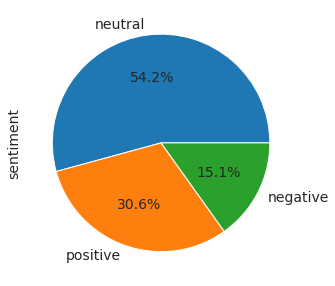

In [287]:
df.sentiment.value_counts().plot(kind='pie',autopct='%1.1f%%')

Text(0.5, 1.0, 'Character Sentiment')

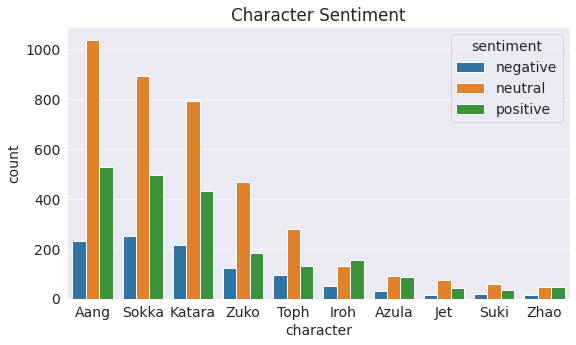

In [288]:
sns.countplot(x='character',hue='sentiment',data=df,order=df.character.value_counts().iloc[:10].index)
plt.title('Character Sentiment')

In [289]:
# Build a counter function to count words
def counter(dialogue):
    cnt = Counter()
    for msgs in dialogue:
        for msg in msgs:
            cnt[msg] += 1
    return cnt

**Finding out if "HONOR" was the most said word by Zuko**

In [290]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

zuko = df.groupby('character')
zuko = zuko.get_group(('Zuko'))
zuko['clean_dialogue'] = zuko['clean_dialogue'].apply(lambda x: word_tokenize(x))
text_cnt = counter(zuko['clean_dialogue'])
j = text_cnt.most_common()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Text(0.5, 1.0, "Zuko's Most Common Words")

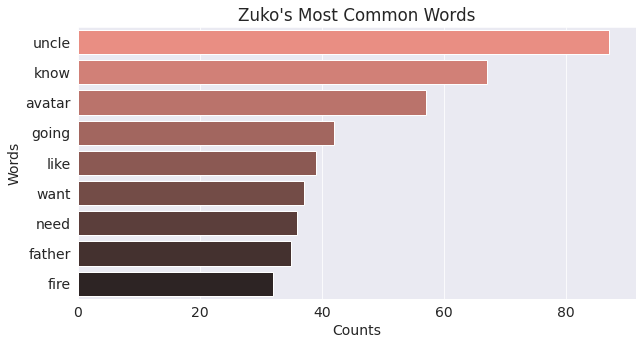

In [291]:
j = pd.DataFrame(j, columns = ['Words', 'Counts'])
j = j.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.color_palette("dark:salmon_r",len(j))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=j, palette=colors)
plt.title('''Zuko's Most Common Words''')

In [292]:
aang= df.groupby('character')
aang = aang.get_group(('Aang'))
aang['clean_dialogue'] = aang['clean_dialogue'].apply(lambda x: word_tokenize(x))
aang_cnt = counter(aang['clean_dialogue'])

katara = df.groupby('character')
katara = katara.get_group(('Katara'))
katara['clean_dialogue'] = katara['clean_dialogue'].apply(lambda x: word_tokenize(x))
katara_cnt = counter(katara['clean_dialogue'])

sokka = df.groupby('character')
sokka = sokka.get_group(('Sokka'))
sokka['clean_dialogue'] = sokka['clean_dialogue'].apply(lambda x: word_tokenize(x))
sokka_cnt = counter(sokka['clean_dialogue'])

iroh = df.groupby('character')
iroh = iroh.get_group(('Iroh'))
iroh['clean_dialogue'] = iroh['clean_dialogue'].apply(lambda x: word_tokenize(x))
iroh_cnt = counter(iroh['clean_dialogue'])

toph = df.groupby('character')
toph = toph.get_group(('Toph'))
toph['clean_dialogue'] = toph['clean_dialogue'].apply(lambda x: word_tokenize(x))
toph_cnt = counter(toph['clean_dialogue'])


a = aang_cnt.most_common()
k = katara_cnt.most_common()
s = sokka_cnt.most_common()
t=  toph_cnt.most_common()
i= iroh_cnt.most_common()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Text(0.5, 1.0, "Iroh's Most Common Words")

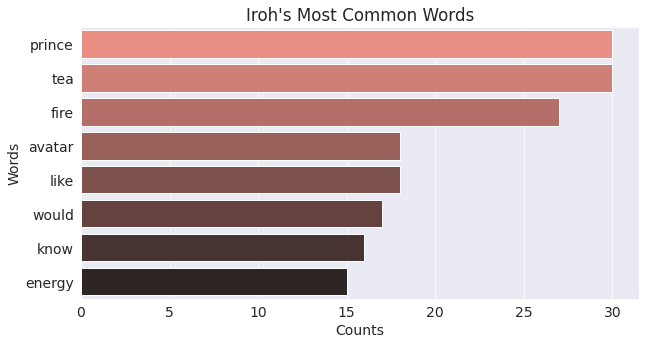

In [294]:
i = pd.DataFrame(i, columns = ['Words', 'Counts'])
i = i.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.color_palette("dark:salmon_r",len(i))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=i, palette=colors)
plt.title('''Iroh's Most Common Words''')

Text(0.5, 1.0, "Aang's Most Common Words")

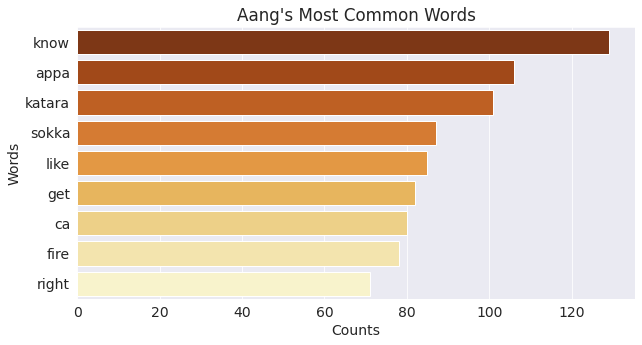

In [295]:
a = pd.DataFrame(a, columns = ['Words', 'Counts'])
a = a.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.color_palette("YlOrBr_r",len(a))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=a, palette=colors)
plt.title('''Aang's Most Common Words''')

Text(0.5, 1.0, "Toph's Most Common Words")

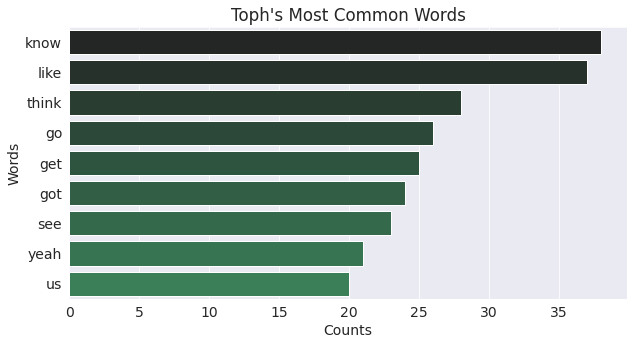

In [296]:
t = pd.DataFrame(t, columns = ['Words', 'Counts'])
t = t.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.dark_palette("seagreen",len(t))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=t, palette=colors)
plt.title('''Toph's Most Common Words''')

Text(0.5, 1.0, "Sokka's Most Common Words")

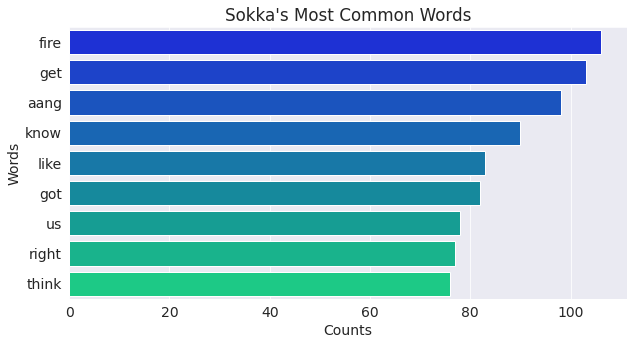

In [297]:
s = pd.DataFrame(s, columns = ['Words', 'Counts'])
s = s.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.color_palette("winter",len(s))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=s, palette=colors)
plt.title('''Sokka's Most Common Words''')

Text(0.5, 1.0, "Katara's Most Common Words")

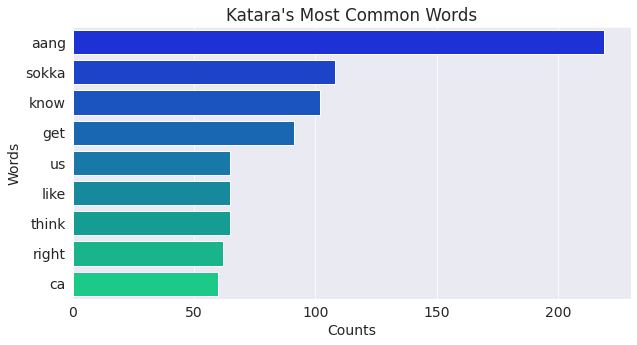

In [298]:
k = pd.DataFrame(k, columns = ['Words', 'Counts'])
k = k.sort_values(by='Counts', ascending=False)[1:10]

colors = sns.color_palette("winter",len(k))

plt.figure(figsize=(10,5))
sns.barplot(y = 'Words' , x = 'Counts', data=k, palette=colors)
plt.title('''Katara's Most Common Words''')

In [224]:
df2 = pd.DataFrame(columns=["Character", "Book", "words"])

In [225]:
data1=pd.read_excel(io.BytesIO(uploaded['avatar.xls'])) 
data1.drop(data1.columns[[0,1,2,4,5,7,9,10,11]], axis = 1, inplace = True)

In [226]:
data1 = data1.rename(columns={"character_words":"dialogue"})

In [227]:
data1 = data1.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [228]:
data1.isnull().sum()

book_num     0
character    0
dialogue     0
dtype: int64

In [229]:
data1.sample()

,book_num,character,dialogue
13067,3,Zuko,Where ... where is he?


In [230]:
removelst = data1.character.value_counts().iloc[5:].index.tolist()
for name in removelst:
    data1 = data1[data1['character'] != name]

In [231]:
data1['word_count'] = data1['dialogue'].str.split().str.len()

In [207]:
data1.to_excel('data1.xlsx', index = False)

In [235]:
# This can be optimized
for character in ["Aang", "Katara", "Sokka"]:
    a1 = data1.loc[1:2243].loc[data1['character'] == character]["word_count"].count()
    a2 = data1.loc[2244:4057].loc[data1['character'] == character]["word_count"].count()
    a3 = data1.loc[4058:6155].loc[data1['character'] == character]["word_count"].count()
    
    df2 = df2.append({'Character' : character , 'Book' : "Water", "words" : a1} , ignore_index=True)
    df2 = df2.append({'Character' : character , 'Book' : "Earth", "words" : a2} , ignore_index=True)
    df2 = df2.append({'Character' : character , 'Book' : "Fire", "words" : a3} , ignore_index=True)
    

Text(0.5, 1.0, 'Character Word Counts')

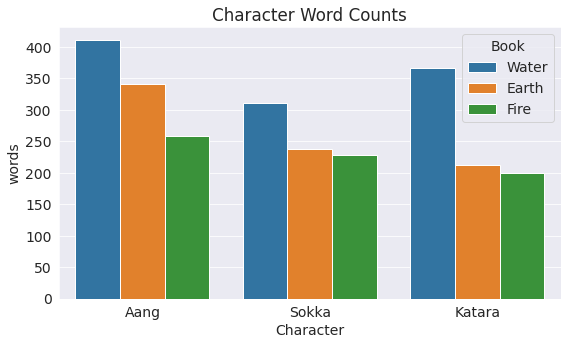

In [237]:
sns.barplot(x='Character',y='words', hue='Book',data=df2, order = data1.character.value_counts().iloc[:3].index)
ax.legend(bbox_to_anchor=(2, 1))
plt.title('Character Word Counts')